# Experiment on Citeseer dataset

In [1]:
# import packages
import numpy as np
import scipy
from scipy.linalg import eigh
import scipy.sparse as sp
import scipy.io as io
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE, spectral_embedding
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import time
import os
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import get_laplacian, remove_self_loops
import math

## Read Data

In [2]:
dataset = Planetoid(root='../../data', name='citeseer')
data = dataset[0]
X = data.x
y = data.y

## Global parameter setting and function

1. global parameter setting,
2. construct the adjacency matrix A and the graph Laplacian.
3. knn recognition rate function,
4. plot curve function,
5. plot tsne function.

In [3]:
class_num = 6
m, D = X.shape
edge_index, edge_weight = get_laplacian(data.edge_index, normalization='sym')
L_sym = torch.sparse.FloatTensor( edge_index, edge_weight, (m, m) )

edge_index, edge_weight = remove_self_loops( edge_index, -edge_weight )
A_sym = torch.sparse.FloatTensor( edge_index, edge_weight, (m, m) )

# Graph Neural Spectral Embedding

### Define the model

In [4]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
class Encoder_linear(nn.Module):
    def __init__(self, n_feat, dim):
        super(Encoder_linear, self).__init__()
        self.W = nn.Parameter(torch.FloatTensor(n_feat, dim))
        self.bias = nn.Parameter(torch.empty(1, dim))
        self.n_feat = n_feat
        self.dim = dim
        self.reset_parameters()

    def reset_parameters(self):
        stdv = math.sqrt(3) / math.sqrt(self.n_feat)
        self.W.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, X):
        X = F.dropout(X, training = self.training, p = 0.9)
        Z = torch.mm(X, self.W) + self.bias
        Z = F.normalize(Z)
        return Z

def LENet( Z, A, beta, K = 32):
    m, d = Z.shape
    alpha = m*(1-beta*0.95)/d
    # ! Propagate
    Y = Z
    Y_all = Y
    for _ in range(K):
        Y = beta * torch.spmm(A, Y)
        Y_all = Y_all + Y
    # ! Linear Transformation
    Y = Y_all
    U, s, _ = torch.linalg.svd( Z.T @ Y, full_matrices = True)
    s_inv_21 = 1 / torch.sqrt(s)
    W = ( U*s_inv_21 ) @ U.T
    Y = np.sqrt(alpha) * (Y @ W)
    return Y

def align_fun(Z, Y):
    return torch.mean( torch.sum( Z*Y, dim = 1 ) )

### Define the train function and parameter

In [6]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class Build_Data(Dataset):
    # Constructor
    def __init__(self, X):
        self.X = X
        self.len = self.X.shape[0]
    # Getting the data
    def __getitem__(self, index):
        return self.X[index], index
    # Getting length of the data
    def __len__(self):
        return self.len

### test the mean classification accuracy

In [7]:
# ! show mean classification accuracy
beta = 0.9
dim_d = 12

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Encoder_linear(n_feat=D, dim=dim_d).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0, maximize = True)

A = A_sym.to(device)
X = X.to(device)
X_Data = Build_Data(X)
train_loader = DataLoader(X_Data, batch_size=512, shuffle=True, drop_last=False)

epoch = 0
align_epoch = []

for iter in range(520):
    if iter % 10 == 0:
        model.eval()
        with torch.no_grad():
            Z = model(X)
            Y = LENet( Z, A, beta, K = 32 )
    model.train()
    for X_batch, index in train_loader:
        optimizer.zero_grad()
        Z_batch = model(X_batch)
        align = align_fun(Z_batch, Y[index])
        align.backward()
        optimizer.step()
        # ! compute align value
        align_epoch.append(align.item())
        epoch = epoch + 1
        print(  'iter:{:04d}'.format(iter+1), 
                'epoch:{:04d}'.format(epoch), 
                '| align_epoch:{:.3f}'.format(align_epoch[-1]) )

iter:0001 epoch:0001 | align_epoch:0.238
iter:0001 epoch:0002 | align_epoch:0.221
iter:0001 epoch:0003 | align_epoch:0.237
iter:0001 epoch:0004 | align_epoch:0.234
iter:0001 epoch:0005 | align_epoch:0.234
iter:0001 epoch:0006 | align_epoch:0.248
iter:0001 epoch:0007 | align_epoch:0.241
iter:0002 epoch:0008 | align_epoch:0.276
iter:0002 epoch:0009 | align_epoch:0.260
iter:0002 epoch:0010 | align_epoch:0.281
iter:0002 epoch:0011 | align_epoch:0.269
iter:0002 epoch:0012 | align_epoch:0.288
iter:0002 epoch:0013 | align_epoch:0.291
iter:0002 epoch:0014 | align_epoch:0.295
iter:0003 epoch:0015 | align_epoch:0.329
iter:0003 epoch:0016 | align_epoch:0.315
iter:0003 epoch:0017 | align_epoch:0.324
iter:0003 epoch:0018 | align_epoch:0.335
iter:0003 epoch:0019 | align_epoch:0.329
iter:0003 epoch:0020 | align_epoch:0.344
iter:0003 epoch:0021 | align_epoch:0.329
iter:0004 epoch:0022 | align_epoch:0.347
iter:0004 epoch:0023 | align_epoch:0.333
iter:0004 epoch:0024 | align_epoch:0.343
iter:0004 epoch:

In [8]:
model.eval()
with torch.no_grad():
    Z = model(X)
    Y = LENet( Z, A, beta, K = 32 )

Z = Z.cpu()
Y = Y.cpu()
Y_norm = normalize(Y)

Z_train = Z[data.train_mask]
Z_test = Z[data.test_mask]
Y_train = Y[data.train_mask]
Y_test = Y[data.test_mask]
Y_norm_train = Y_norm[data.train_mask]
Y_norm_test = Y_norm[data.test_mask]

y_train = y[data.train_mask]
y_test = y[data.test_mask]

clf = LogisticRegression()
clf.fit( Z_train, y_train )
acc_Z = clf.score( Z_test, y_test )

clf = LogisticRegression()
clf.fit( Y_train, y_train )
acc_Y = clf.score( Y_test, y_test )

clf = LogisticRegression()
clf.fit( Y_norm_train, y_train )
acc_Y_norm = clf.score( Y_norm_test, y_test )

In [9]:
acc_Z, acc_Y, acc_Y_norm

(0.69, 0.691, 0.686)

### Parameter setting tip

In [10]:
np.power( np.linalg.norm(Y, 'fro'), 2 )

4275.524757156381

## Save figure

In [11]:
Y_tsne = TSNE(
            n_components=2,
            perplexity=100,
            init="pca",
            random_state=42,
            ).fit_transform( Y )

d:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
d:\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [12]:
def symmetric_normalize(A):
    # normalize a symmeteric adjacency matrix
    row_sum = A.sum(axis=1)
    row_sum = (row_sum==0)*1 + row_sum
    D_inv_21 = sp.csr_array( sp.diags( np.power(row_sum, -0.5) ) )
    A_sym = D_inv_21 @ A @ D_inv_21
    return A_sym

A_plot = sp.coo_matrix( (np.ones_like(data.edge_index[0]), (data.edge_index[0], data.edge_index[1])), shape=(data.num_nodes, data.num_nodes) )

A_plot = sp.csr_array(A_plot)
# Symmetry: A := A + (AT-A)[AT>A]
A_plot =  A_plot + (A_plot.T - A_plot) * (A_plot.T > A_plot)

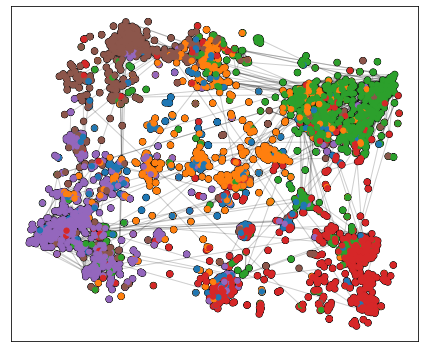

In [13]:
def plot_scatter_with_edge(ax, Z, fig_paras, A):
    def plot_graph_edges(A):
        indptr = A.indptr
        indices = A.indices
        repeat_num = indptr[1:] - indptr[:-1]
        edge_begin = np.repeat(Z, repeat_num, axis = 0)
        edge_over = np.vstack( [ Z[indices[indptr[i]:indptr[i+1]]] for i in range(m) ] )
        x,y = edge_begin[:, 0], edge_begin[:, 1]
        u,v = edge_over[:, 0]-x, edge_over[:, 1]-y
        ax.quiver(x,y, u,v, color='k', lw=0.1, alpha=0.1, angles='xy', scale_units='xy', scale=1)
    plot_graph_edges(A)
    ax.scatter(Z[:, 0], Z[:, 1], **fig_paras, edgecolors='k', lw=2, zorder=1,s=28)
    ax.scatter(Z[:, 0], Z[:, 1], **fig_paras, zorder=1, s=28)

colors = np.asarray( ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9'] )
fig_paras = {
            'c': colors[y],
            # 'edgecolors': 'gray',
            # 'lw': 0.05,
            'alpha': 1,
            # 's': 20, 
}
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
plot_scatter_with_edge(ax, Y_tsne, fig_paras, A_plot)
fig.tight_layout()

In [14]:
X_norm = normalize(X.cpu())

X_s = np.vstack( [ X_norm[y==j] for j in range(7) ] )
Y_s = np.vstack( [ Y_norm[y==j] for j in range(7) ] )

sim_X = np.abs(X_s @ X_s.T)
sim_Y = np.abs(Y_s @ Y_s.T)

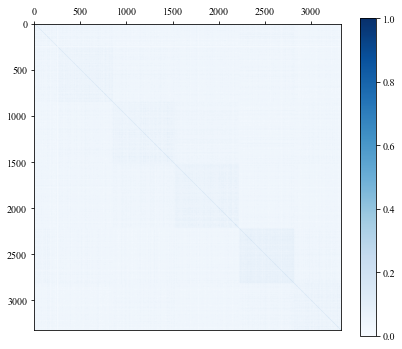

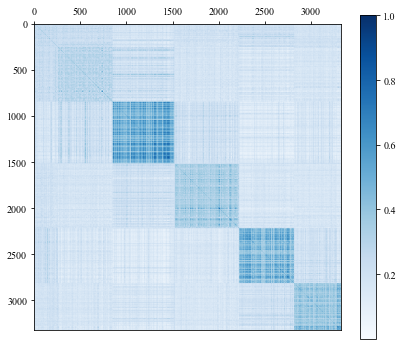

In [15]:
def plot_heatmap(fig, ax, sim, cmap):
    im = ax.imshow(sim, cmap=cmap, origin='upper')
    ax.xaxis.tick_top()
    ax.set_box_aspect(1)
    fig.colorbar(im)

cmap = 'Blues'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fig_X, ax_X = plt.subplots(figsize=(6, 5))
fig_Z, ax_Z = plt.subplots(figsize=(6, 5))
plot_heatmap(fig_X, ax_X, sim_X, cmap)
plot_heatmap(fig_Z, ax_Z, sim_Y, cmap)
fig_X.tight_layout()
fig_Z.tight_layout()

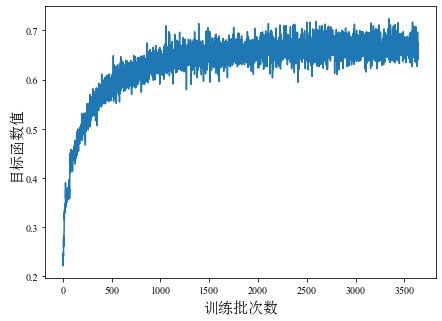

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
fontsize = 15
color_origin = 'tab:blue'

fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel('训练批次数', fontproperties="SimSun", fontsize=fontsize)
ax.set_ylabel('目标函数值', fontproperties="SimSun", color='k', fontsize=fontsize)
# ax.tick_params(axis='y', labelcolor=color_origin)
ax.plot(align_epoch, label='loss', color=color_origin)